# Preparations

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import datetime
import yfinance as yf
import pandas_datareader.data as web

### Create time boundaries

In [5]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

In [7]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate portfolios

### Load the stock data

In [10]:
gs10 = web.DataReader('GS10', 'fred', start_date, end_date)
riskfreerate = gs10.iloc[-1]['GS10']/100

In [61]:
def get_data(portfolio, start_date, end_date):
    stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
    stock_data = stock_data['Adj Close']
    stock_data = stock_data.reset_index()
    selected = list(stock_data.columns[1:])
    returns = stock_data[selected].pct_change()
    mean_returns = returns.mean() * 252
    cov = returns.cov()
    return mean_returns, cov    

In [63]:
mean_returns, cov = get_data(portfolio, start_date, end_date)

[*********************100%***********************]  13 of 13 completed


In [65]:
mean_returns

Ticker
AAPL     0.337225
ABBV     0.268272
BAC      0.162397
BTI      0.115356
C        0.101853
CMCSA    0.050881
FDX      0.216806
GPS      0.296250
HPQ      0.264272
INTC    -0.039110
PFE      0.045804
T        0.061011
V        0.141429
dtype: float64

### Calculate metrics current portfolio

In [14]:
def get_metrics(weights):
    return_portfolio = np.dot(weights , mean_returns)*252
    std = np.sqrt(np.dot(np.transpose(weights), np.dot(cov, weights)))
    sharpe_ratio = (return_portfolio - riskfreerate)/std
    return return_portfolio, std, sharpe_ratio

In [15]:
current_return, current_std, current_sharpe_ratio = get_metrics(current_weights)

In [16]:
print(f'Current portfolio return: {current_return}')
print(f'Current portfolio volatility: {current_std}')
print(f'Current portfolio sharpe ratio: {current_sharpe_ratio}')

Current portfolio return: 0.18559332715153637
Current portfolio volatility: 0.014521891404603117
Current portfolio sharpe ratio: 10.218595017485049


### Generate random portfolios

In [18]:
def return_portfolios(num_portfolios=25000, low=0, high=1):
    port_returns = []
    port_volatility = []
    port_sharpe_ratio = []
    stock_weights = []
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(portfolio_len)
        weights /= np.sum(weights)
        returns, volatility, sharpe_ratio = get_metrics(weights)
        port_returns.append(returns)
        port_volatility.append(volatility)
        port_sharpe_ratio.append(sharpe_ratio)
        stock_weights.append(weights)
    
    portfolios = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe ratio': port_sharpe_ratio}
    
    for counter,symbol in enumerate(portfolio):
        portfolios[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolios)
    
    column_order = ['Returns', 'Volatility', 'Sharpe ratio'] + [stock+' Weight' for stock in portfolio]
    
    df = df[column_order]
   
    return df

In [19]:
# Find a set of random portfolios
random_portfolios = return_portfolios()

### Calculate metrics equally-weighted portfolio

In [21]:
equally_weights = portfolio_len * [1/portfolio_len]
ew_return, ew_std, ew_sharpe_ratio = get_metrics(equally_weights)

In [22]:
print(f'Equally-weighted portfolio return: {ew_return}')
print(f'Equally-weighted portfolio volatility: {ew_std}')
print(f'Equally-weighted portfolio sharpe ratio: {ew_sharpe_ratio}')

Equally-weighted portfolio return: 0.15557271486927984
Equally-weighted portfolio volatility: 0.014598129285441405
Equally-weighted portfolio sharpe ratio: 8.108759181036435


### Calculate metrics max sharpe ratio random portfolio

In [24]:
max_sharpe_random_index = random_portfolios['Sharpe ratio'].argmax()
max_sharpe_random_weights = random_portfolios.loc[max_sharpe_random_index, 'AAPL Weight':].tolist()
max_sharpe_random_return, max_sharpe_random_std, max_sharpe_random_ratio = get_metrics(max_sharpe_random_weights)

In [25]:
print(f'Max sharpe ratio portfolio return: {max_sharpe_random_return}')
print(f'Max sharpe ratio portfolio volatility: {max_sharpe_random_std}')
print(f'Max sharpe ratio portfolio sharpe ratio: {max_sharpe_random_ratio}')

Max sharpe ratio portfolio return: 0.21693691673057688
Max sharpe ratio portfolio volatility: 0.014064789990995981
Max sharpe ratio portfolio sharpe ratio: 12.77921084108907


# Results

### Draw results

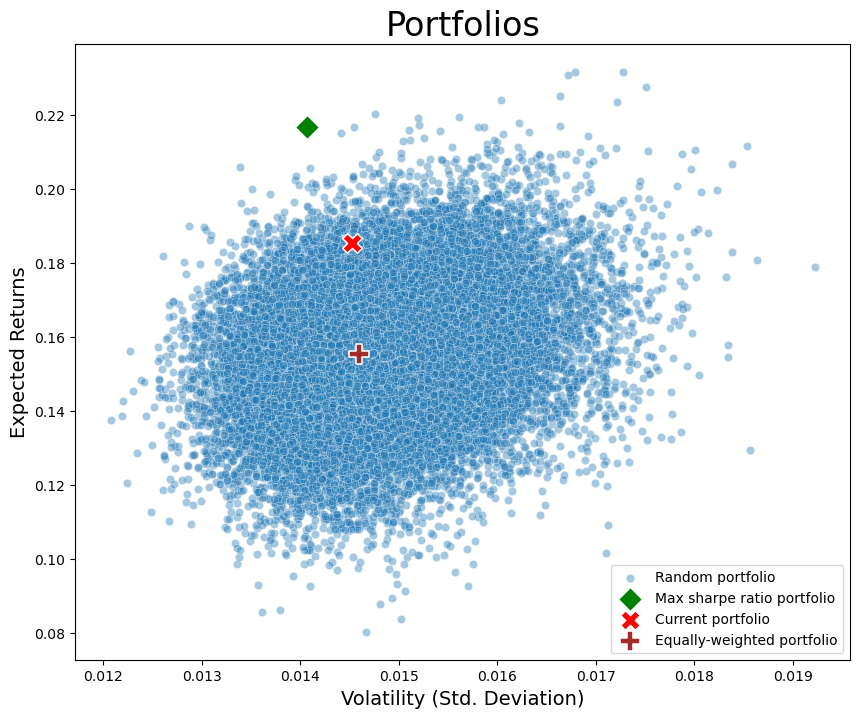

In [28]:
sns.scatterplot(data=random_portfolios, x='Volatility', y='Returns', alpha=0.4, label='Random portfolio')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Portfolios', fontsize=24)

sns.scatterplot(x=[max_sharpe_random_std], y=[max_sharpe_random_return], marker='D', color='green', s=150, label='Max sharpe ratio portfolio')
sns.scatterplot(x=[current_std], y=[current_return], marker='X', color='red', s=200, label='Current portfolio')
sns.scatterplot(x=[ew_std], y=[ew_return], marker='P', color='brown', s=200, label='Equally-weighted portfolio')

plt.legend()

plt.show()

### Print portfolios weights

In [30]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
max_sharpe_ratio_random_portfolio = pd.DataFrame(max_sharpe_random_weights, index=portfolio, columns=['Max sharpe ratio random weights'])

portfolios = pd.concat([current_portfolio, max_sharpe_ratio_random_portfolio], axis=1)

portfolios

,Current weights,Max sharpe ratio random weights
AAPL,0.1269,0.180420
ABBV,0.1082,0.135123
BAC,0.0473,0.028488
BTI,0.0762,0.133575
C,0.0441,0.041099
CMCSA,0.0627,0.002620
FDX,0.1069,0.151754
GPS,0.1006,0.045473
HPQ,0.0716,0.118423
INTC,0.0401,0.003242


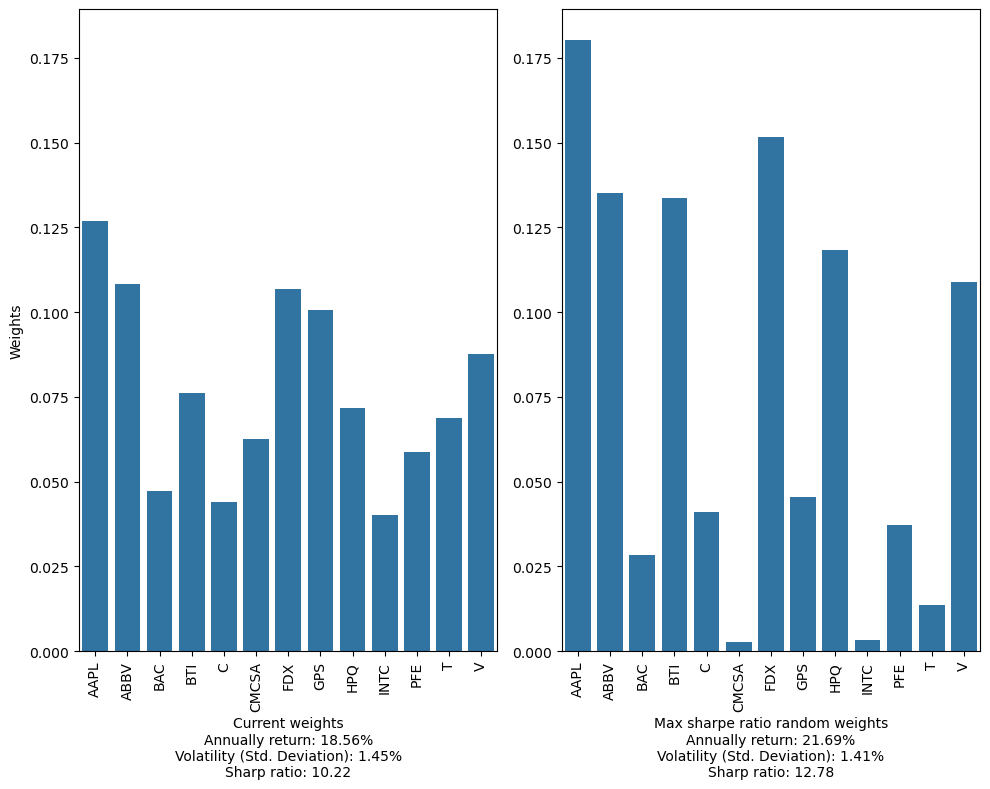

In [31]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"""Current weights
Annually return: {round(current_return*100,2)}%
Volatility (Std. Deviation): {round(current_std*100,2)}%
Sharp ratio: {round(current_sharpe_ratio,2)}""");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
ax2.sharey(ax1)
sns.barplot(x=portfolios.index, y=portfolios['Max sharpe ratio random weights'])
plt.ylabel("");
plt.xlabel(f"""Max sharpe ratio random weights
Annually return: {round(max_sharpe_random_return*100,2)}%
Volatility (Std. Deviation): {round(max_sharpe_random_std*100,2)}%
Sharp ratio: {round(max_sharpe_random_ratio,2)}""");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()